# Computing MBHB signal and evluating SNR

Import required modules

In [1]:
%matplotlib inline
import numpy as np
import sys, os, re
from scipy.interpolate import InterpolatedUnivariateSpline as spline


import LISAConstants as LC

from LISAhdf5 import LISAhdf5,ParsUnits,Str
from optparse import OptionParser
import GenerateFD_SignalTDIs as GenTDIFD
import LW_simple as LW
import pyFDresponse as FD_Resp
import pyIMRPhenomD



import tdi, Cosmology
import matplotlib.pyplot as plt

import MBHBtemplateFU as MBHBt


/Users/stas/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Define the name of hdf5 file (root name) and the seed

In [2]:
fNh5 = "/Users/stas/Projects/LISA/MLDC/software/LDCpipeline/scripts/Data/MBHB_M1e6_m1e6_z1_Chi0.5_chi0.5_Inst_WithData_GWOnly.hdf5"
seed = 1911

## Define the useful functions

In [3]:
def Window(tm):

    xl = 1000.0
    ind_r = np.argwhere(tm[-1]-tm <= 1000.0)[0][0]
    xr = tm[ind_r]
    # print (xr)
    kap = 0.005
    winl = 0.5*(1.0 + np.tanh(kap*(tm-xl)))
    winr = 0.5*(1.0 - np.tanh(kap*(tm-xr)))
    # plt.plot(tm, winl)
    # plt.plot(tm, winr)
    # plt.grid(True)
    # plt.show()
    return (winl*winr)


def ComputeNorm(x, S, fr):
    #{{{
    df = fr[1]-fr[0]
    SNR2 = 4.0*df * np.sum(np.absolute(x)**2/S)
    #print ("df = ", df)
    # plt.loglog(fr, S)
    # plt.loglog(fr, np.real(x*np.conjugate(x)) )
    # #plt.loglog(fr, np.absolute(x) )
    # plt.show()
    return (SNR2)
    #}}}

    
def ComputeSNR_MBHB(pMBHB):
    #{{{
    if Str(pMBHB.get('Approximant'))=='IMRPhenomD':
        print ("Yes, requested IMRP_D model, we can proceed")
    else:
        print ("Unknown FD model:", Str(pMBHB.get('Approximant')))
        raise NotImplementedError

    fr, Xf, Yf, Zf = GenTDIFD.ComputeMBHBXYZ_FD(pMBHB)

    ix = np.argwhere(np.absolute(Xf) > 0.0)[0][0]
    Af = (Zf - Xf)/np.sqrt(2.0)
    Ef = (Xf - 2.0*Yf + Zf)/np.sqrt(6.0)
    Tf = (Xf + Yf + Zf)/np.sqrt(3.0)

    Sa = tdi.noisepsd_AE(fr[ix:], model='Proposal', includewd=None)
    St = tdi.noisepsd_T(fr[ix:], model='Proposal')

    SNR2A = ComputeNorm(Af[ix:], Sa, fr[ix:])
    SNR2E = ComputeNorm(Ef[ix:], Sa, fr[ix:])
    SNR2T = ComputeNorm(Tf[ix:], St, fr[ix:])
    SNR = np.sqrt(SNR2A + SNR2E + SNR2T)

    return(SNR)


def GetParams(pGW):
    # print (pGW.get('Mass1')*1.e-6, pGW.get('Mass2')*1.e-6)
    m1 = pGW.get('Mass1')
    m2 = pGW.get('Mass2')
    tc = pGW.get('CoalescenceTime')
    chi1 = pGW.get('Spin1')*np.cos(pGW.get('PolarAngleOfSpin1'))
    chi2 = pGW.get('Spin2')*np.cos(pGW.get('PolarAngleOfSpin2'))
    theL = pGW.get('InitialPolarAngleL')
    phiL = pGW.get('InitialAzimuthalAngleL')
    longt = pGW.get('EclipticLongitude')
    lat = pGW.get('EclipticLatitude')
    phi0 = pGW.get('PhaseAtCoalescence')
    z = pGW.get("Redshift")
    # m1 = m1*(1.0+z)
    # m2 = m2*(1.0+z)
    DL = Cosmology.DL(z, w=0)[0]
    dist = DL * 1.e6 * LC.pc
    print ("DL = ", DL*1.e-3, "Gpc")
    print ("Compare DL:", pGW.getConvert('Distance',LC.convDistance,'mpc'))
    bet = lat
    lam = longt
    incl = np.arccos( np.cos(theL)*np.sin(lat) + np.cos(lat)*np.sin(theL)*np.cos(longt-phiL) )
    up_psi = np.sin(bet)*np.sin(theL)*np.cos(lam - phiL) - np.cos(theL)*np.cos(bet)
    down_psi = np.sin(theL)*np.sin(lam - phiL)
    psi = np.arctan2(up_psi, down_psi)

    # up_psi = np.sin(bet)*np.cos(lam - phiL)*np.sin(incl) - np.cos(incl)*np.cos(bet)
    # down_psi = np.cos(bet)*np.sin(lam - phiL)
    # psi = np.arctan2(up_psi, down_psi)
    #print ("psi = ", psi)

    return(m1, m2, tc, chi1, chi2, dist, incl, bet, lam, psi, phi0, DL)




## Reading parameters of the source in the hdf5 file

In [4]:
fh5 = LISAhdf5(fNh5)
#NSrc = fh5.getSourcesNum()
GWs = fh5.getSourcesName()
NSrc = len(GWs)

pMBHB = fh5.getSourceParameters(GWs[0])

print ("num sources: ", NSrc)
print ("The chosen source:")
pMBHB.display()

num sources:  1
The chosen source:
	Approximant IMRPhenomD [ModelName]
	AzimuthalAngleOfSpin1 5.593007021750822 [Radian]
	AzimuthalAngleOfSpin2 0.8212581562338762 [Radian]
	Cadence 10.0 [Seconds]
	CoalescenceTime 28000000.0 [Second]
	Distance 6.8230904801798165 [Gpc]
	EclipticLatitude 1.0 [Radian]
	EclipticLongitude 1.0 [Radian]
	InitialAzimuthalAngleL 1.0 [Radian]
	InitialPolarAngleL 1.0 [Radian]
	Mass1 1000000.0 [SolarMass]
	Mass2 1000000.0 [SolarMass]
	ObservationDuration 31557600.0 [Seconds]
	PhaseAtCoalescence 5.192651342878691 [Radian]
	PolarAngleOfSpin1 0.0 [Radian]
	PolarAngleOfSpin2 0.0 [Radian]
	Redshift 1.0 [dimensionless]
	Spin1 0.5 [MassSquared]
	Spin2 0.5 [MassSquared]



## Generating signal using LDC/LISACode

In [5]:
h5_LC = fNh5[:-5] + "_LC.hdf5"
print (h5_LC)
runDir = "/Users/stas/Projects/LISA/MLDC/software/LDCpipeline/scripts/"
### The line below copies the hdf5 file
#os.system("cp "+ fNh5 + "  " + h5_LC)

### Computing h+, hx
os.system("python " + runDir + "Compute_hphc.py -v  " + h5_LC)

### Uncomment below if Instrument is not configured in hdf5 file
### make sure that your duration and timestep agree with what was used to produce h+, hx
#os.system("python ConfigureInstrument.py  --duration=41943040.0  --timeStep=10.0  --orbits='MLDC_Orbits'  " + fNh5)

### Computing response using LISACode
### The --NoNoise option is used to create the noiseless data.
#print ("python " + runDir + "RunSimuLC2.py  --NoNoise  -v  "  + h5_LC)
#os.system("python " + runDir + "RunSimuLC2.py  --NoNoise  -v  "  + h5_LC)

print (h5_LC)



/Users/stas/Projects/LISA/MLDC/software/LDCpipeline/scripts/Data/MBHB_M1e6_m1e6_z1_Chi0.5_chi0.5_Inst_WithData_GWOnly_LC.hdf5
/Users/stas/Projects/LISA/MLDC/software/LDCpipeline/scripts/Data/MBHB_M1e6_m1e6_z1_Chi0.5_chi0.5_Inst_WithData_GWOnly_LC.hdf5


/Users/stas/Projects/LISA/MLDC/software/LDCpipeline/scripts/Data/MBHB_M1e6_m1e6_z1_Chi0.5_chi0.5_Inst_WithData_GWOnly_LC.hdf5


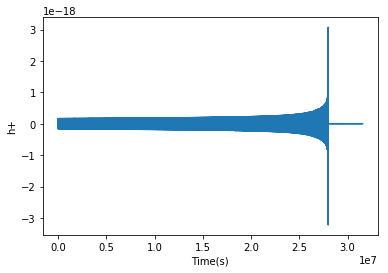

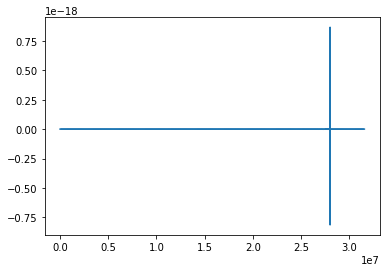

In [6]:
print (h5_LC)
TD5 = LISAhdf5(h5_LC)
thphc = TD5.getSourceHpHc('MBHB-0')
plt.plot(thphc[:,0],thphc[:,1])
plt.xlabel('Time(s)')
plt.ylabel('h+')
plt.show()

tdTDI = TD5.getPreProcessTDI()
plt.plot(tdTDI[:,0],tdTDI[:,1], label="TD - waveform")
plt.show()

## Generate FD signal (no noise)

In [7]:
### create hdf5 file where we store the data
h5_FD = fNh5[:-5] + "_FD.hdf5"
#print (tmp_h5)
os.system("cp "+ fNh5 + "  " + h5_FD)

### Computing the X, Y, Z in frequency domain using approximate response function
fr, Xfp, Yfp, Zfp = GenTDIFD.ComputeMBHBXYZ_FD(pMBHB)
del_t = pMBHB.get("Cadence")
### Transforming to the time domain
tm, Xtp, Ytp, Ztp = GenTDIFD.ComputeTD(Xfp, Yfp, Zfp, del_t)
Tobs = pMBHB.get("ObservationDuration")
### Trancating the data if it is longer than the observation time
i_end = np.argwhere(tm > Tobs)[0][0]
Xtp = Xtp[:i_end]
Ytp = Ytp[:i_end]
Ztp = Ztp[:i_end]
tim = tm[:i_end]

# Write the FD data to the hdf5file
f1h5 = LISAhdf5(h5_FD)
tdis = np.transpose(np.array([tim, Xtp, Ytp, Ztp]))
f1h5.addPreProcess(ParsUnits(), overwrite=True, TDIdata=tdis)

ellapsed time  1.1757681369781494
Stas 0.05 1.5844043907017825e-08 3155761 3155759.9999993327 3155760.0 3.351735842064868e-21
i_b =  2196 3.4793520419803785e-05 3.4793520419811144e-05 2195.9999999995357


## Generate Long-Wavelength approximation signal (no noise)

In [8]:
m1, m2, tc, chi1, chi2, dist, incl, bet, lam, psi, phi0, DL = GetParams(pMBHB)

### Computing h22 using PhenomD
m1_SI = m1*LC.MsunKG ## in kg
m2_SI = m2*LC.MsunKG ## in kg
dist_SI = DL*1e6*LC.pc ## in meters


fRef = 1.e-3 ### We define ref freq to be 1mHz

M = m1+m2
Mt = M*LC.MTsun
Mc = FD_Resp.funcMchirpofm1m2(m1, m2)
f0 = FD_Resp.funcNewtonianfoft(Mc, 2.0*Tobs/LC.YRSID_SI)
df = 0.5/Tobs  ### generating waveform 2*Tobs, we will chop it off later
f0 = np.floor(f0/df)*df ### making sure f

fmax = GenTDIFD.MfCUT_PhenomD/Mt
Nf = int((fmax-f0)/df)
#print ("Number of points:", Nf, fmax, f0)
freq_all = np.arange(Nf)*df + f0

#### GENERATING  IMRPhenomD waveform (phase and amplitude)
wf_PhD_class = pyIMRPhenomD.IMRPhenomDh22AmpPhase(freq_all, phi0, fRef, m1_SI, m2_SI, chi1, chi2, dist_SI)
wf_PhD = wf_PhD_class.GetWaveform() # freq, amp, phase

frS = wf_PhD[0]  ### Freq array fro which h22 was computed
phS = wf_PhD[2]  ### phase of h22
ampS = wf_PhD[1] ### amplitude of h22

### putting correspondence between frequency and time:
tfspline = spline(frS, 1/(2.*np.pi)*(phS-phS[0])).derivative()
tfvec = tfspline(frS) ### time array corresponding to the GW frequency

Shift = tfvec[-1] - tc  
tfvec = tfvec - Shift   ### shifting so that tc is the last point

LW_MBHB = LW.LW(incl, bet, lam, psi)

### Computing the Response and Doppler phase delay
phR, RX, RY, RZ = LW_MBHB.ComputeResponseMBHB(frS, ampS, phS, tc)

phasetimeshift = -2.0*np.pi*tc*frS   #### shifting the waveform so that tc is at tc.
common = ampS* np.exp(1.0j* (-phS + phR + phasetimeshift))   #### fast varying part

### TDIs in freq. domain for the freqs defined in frS
Xf_lw = RX*common
Yf_lw = RY*common
Zf_lw = RZ*common

### Casting them to the Fourier bins
df = frS[1]-frS[0]
# I want samplign rate to be del_t
fmx = 0.5/del_t
Nf = int(fmx/df+1)
freq = np.arange(Nf)*df

i_b = int(np.rint(frS[0]/df))

Xf = np.zeros(Nf, dtype='complex128')
Yf = np.zeros(Nf, dtype='complex128')
Zf = np.zeros(Nf, dtype='complex128')
Xf[i_b:i_b+len(Xf_lw)] = np.copy(Xf_lw)
Yf[i_b:i_b+len(Xf_lw)] = np.copy(Yf_lw)
Zf[i_b:i_b+len(Xf_lw)] = np.copy(Zf_lw)

### FFT to time domain
tm, Xlw, Ylw, Zlw = LW_MBHB.FrtoTm(del_t, Xf, Yf, Zf)

print(len(tm), len(Xlw))

### Chopping off very low freqs and keeping Tobs duraition
ind0 = int(Tobs/del_t)+1

tm = tm[:ind0]
Xlw = Xlw[:ind0]
Ylw = Ylw[:ind0]
Zlw = Zlw[:ind0]

print(len(tm), len(Xlw))



DL =  6.8230904801798165 Gpc
Compare DL: 6823.090480179816
orbital eccentricity 0.0048241852180789906
6311518 6311518
3155761 3155761


## Plotting waveforms in time domain

(3155761, 4) 3155761 3155761 3155761
[10. 20. 30.] [ 0. 10. 20.] [ 0. 10. 20.]


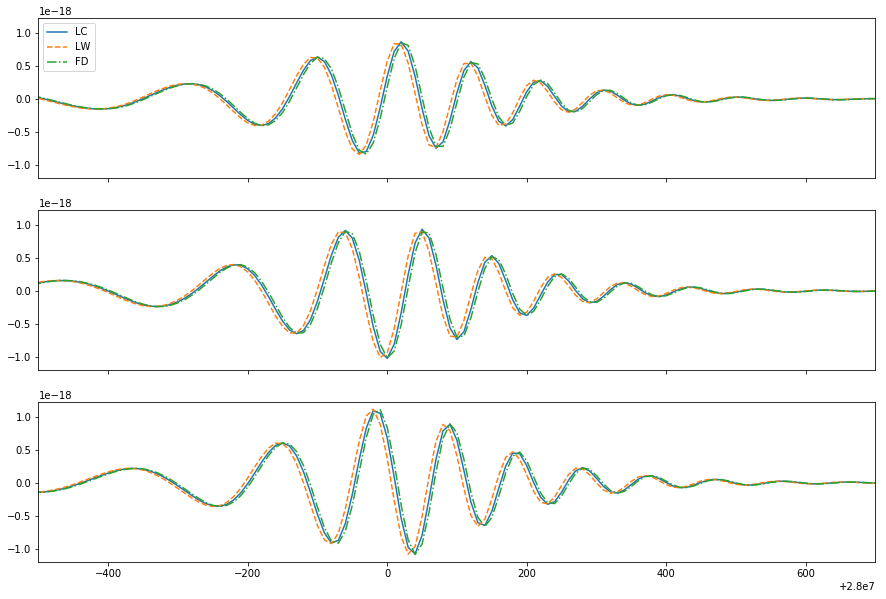

In [39]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, ax = plt.subplots(3, sharex=True, sharey=True)

print (np.shape(tdTDI), len(tm), len(Xlw), len(tim))
### BE CAREFULL!!! look at the start time of each data and note that LISACode data starts with t0=del_t, others with t0=0
print (tdTDI[:3, 0], tm[:3], tim[:3])

ax[0].plot(tdTDI[:,0], tdTDI[:, 1], label="LC")
ax[0].plot(tm[1:], Xlw[1:], '--', label="LW")
ax[0].plot(tim[1:], Xtp[1:], '-.', label="FD")
ax[0].set_xlim([2.79995e7, 2.80007e7])
ax[0].legend(loc=2)

ax[1].plot(tdTDI[:,0], tdTDI[:, 2], label="LC")
ax[1].plot(tm[1:], Ylw[1:], '--', label="LW")
ax[1].plot(tim[1:], Ytp[1:], '-.', label="FD")

ax[2].plot(tdTDI[:,0], tdTDI[:, 3], label="LC")
ax[2].plot(tm[1:], Zlw[1:], '--', label="LW")
ax[2].plot(tim[1:], Ztp[1:], '-.', label="FD")


## Computing SNRs

1577881 1577881 1577881


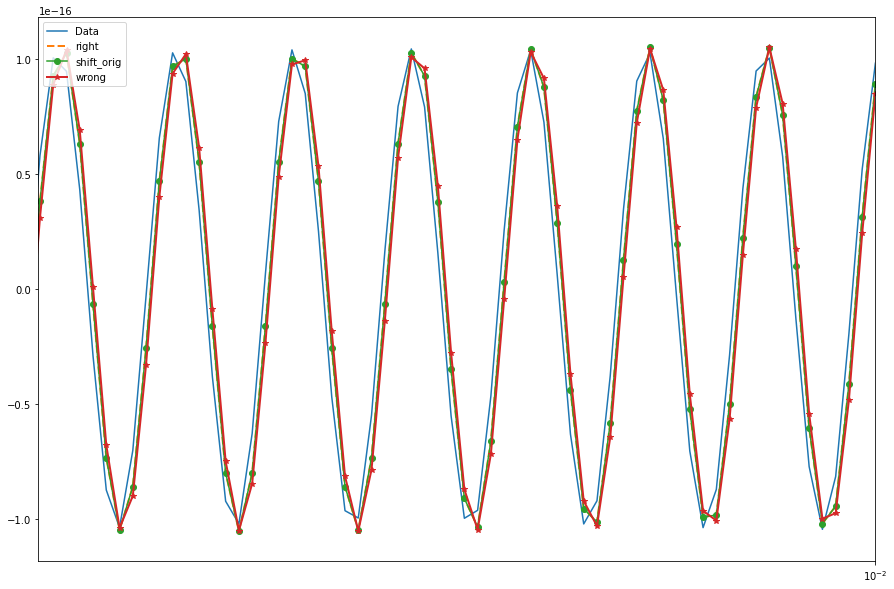

1577881 1577881
SNRs: [6554.57714339 6516.86180556 6538.97725091 6470.57954919]


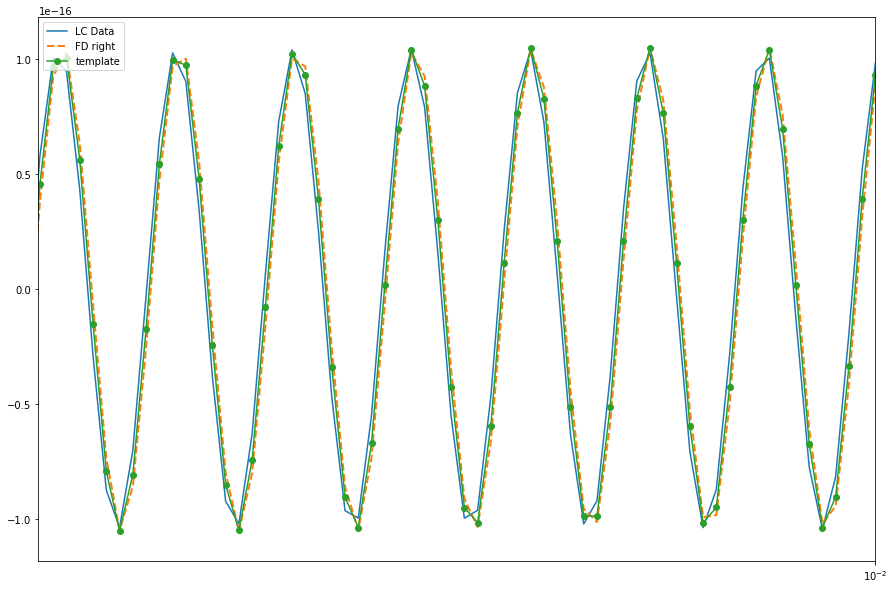

In [38]:
### Windowing the data and FFT-ing
win = Window(tdTDI[:,0]) 
# Xdf = np.fft.rfft(tdTDI[:, 1]*win)*del_t
Xdf = np.fft.rfft(tdTDI[:-1, 1])*del_t
Ydf = np.fft.rfft(tdTDI[:, 2]*win)*del_t
Zdf = np.fft.rfft(tdTDI[:, 3]*win)*del_t

Adf = (Zdf - Xdf)/np.sqrt(2.0)
Edf = (Xdf - 2.0*Ydf + Zdf)/np.sqrt(6.0)


df = 1.0/Tobs
fmx = 0.5/del_t
Nf = int(np.rint(fmx/df)+1)
freqT = np.arange(Nf)*df

#Xfp1 = np.fft.rfft(Xtp[:-1])  
Xfp1 = np.fft.rfft(Xtp[:])*del_t#*np.exp(2.0j*np.pi*freqT*del_t) 
Xfp2 = np.fft.rfft(Xtp[1:])*del_t

print (len(Xdf), len(Xfp1), len(Xfp2))

plt.semilogx(freqT, np.real(Xdf), label="Data")
plt.semilogx(freqT, np.real(Xfp2),'--', lw=2, label="right")

plt.semilogx(fr[::2], np.real(Xfp*np.exp(2.0j*np.pi*fr*del_t))[::2], '-o', label="shift_orig")
# plt.semilogx(fr[::2], np.real(Xfp)[::2], '-o')
plt.semilogx(freqT, np.real(Xfp1),'-*', lw=2, label="wrong")
#plt.xlim([1.e-2*0.9995, 1.e-2])
plt.xlim([1.e-2*0.9998, 1.e-2])
plt.legend(loc=2)
plt.show()


Sx = tdi.noisepsd_X(freqT[1:], model='Proposal', includewd=None)
imin = 1
imax = len(freqT)-1
# Xfp_p = Xfp[::2]
Xfp_p = (Xfp*np.exp(2.0j*np.pi*fr*2.0*del_t))[::2]
print (len(freqT), len(Xfp_p))

SNR2_0 = (4.0*df) * np.sum(np.real(Xdf[imin:imax]*np.conjugate(Xdf[imin:imax])/Sx[imin:imax]))
SNR2_1 = (4.0*df) * np.sum(np.real(Xdf[imin:imax]*np.conjugate(Xfp1[imin:imax])/Sx[imin:imax]))
SNR2_2 = (4.0*df) * np.sum(np.real(Xdf[imin:imax]*np.conjugate(Xfp2[imin:imax])/Sx[imin:imax]))
SNR2_3 = (4.0*df) * np.sum(np.real(Xdf[imin:imax]*np.conjugate(Xfp_p[imin:imax])/Sx[imin:imax]))

SNRs = np.array([SNR2_0, SNR2_1, SNR2_2, SNR2_3])
print ("SNRs:", np.sqrt(SNRs))


# GenerateFDtempl(phi0, fRef, m1, m2, a1, a2, dist, inc, lam, beta, psi, Tobs, tc, del_t, tShift=0.0, fmin=1.e-5, fmax=0.1, frqs=None, resf=None):
# pyIMRPhenomD.IMRPhenomDh22AmpPhase(freq_all, phi0, fRef, m1_SI, m2_SI, chi1, chi2, dist_SI)
# m1, m2, tc, chi1, chi2, dist, incl, bet, lam, psi, phi0, DL

fr_hm, Xfull, Yfull, Zfull, wfTDI = MBHBt.GenerateFDtempl(phi0, fRef, m1, m2, chi1, chi2, DL, incl, lam, bet, psi, Tobs, tc, del_t, resf=df)

plt.semilogx(freqT, np.real(Xdf), label="LC Data")
plt.semilogx(freqT, np.real(Xfp2),'--', lw=2, label="FD right")
plt.semilogx(fr_hm, np.real(Xfull), '-o', label="template")
plt.xlim([1.e-2*0.9998, 1.e-2])
plt.legend(loc=2)
plt.show()

# print (freqT - fr_hm)